# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [245]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Processing - Portfolio Data

The first step is to view to data

In [246]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


One-hot encode the "channels" column to create four columns (email, mobile, social and web) with values of 0 or 1

In [247]:
def one_hot_channels(data):
    """ One-hot encoding of the "channels" feature.
        Args: data - this will be the portfolio dataset
        Outputs: "email" - 0 or 1
                 "mobile" - 0 or 1
                 "web" - 0 or 1
                 "social" - 0 or 1
    """
    channels = data["channels"]
    
    if "email" in channels:
        data["email"] = 1
    elif "email" not in channels:
        data["email"] = 0
        
    if "mobile" in channels:
        data["mobile"] = 1
    elif "mobile" not in channels:
        data["mobile"] = 0
        
    if "social" in channels:
        data["social"] = 1
    elif "social" not in channels:
        data["social"] = 0
        
    if "web" in channels:
        data["web"] = 1
    elif "web" not in channels:
        data["web"] = 0
        
    return data[["email","mobile","web","social"]]

In [248]:
#Apply the function to the dataset

portfolio[["email","mobile","web","social"]] = portfolio.apply(lambda row: one_hot_channels(
    row),axis=1)

In [249]:
# Remove the "channels" column

portfolio.drop(columns=["channels"],inplace=True)

In [250]:
# Convert the "duration" feature from days to hours to make it constistent with the other datsets

portfolio["duration"] = portfolio["duration"]*24
portfolio

,reward,difficulty,duration,offer_type,id,email,mobile,web,social
0,10,10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,0,1
1,10,10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,96,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,1,0
5,3,7,168,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,240,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,72,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,0,1
8,5,5,120,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,168,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


Convert the "offer_type" column from text to numeric

In [251]:
def convert_type(data):
    """ Convert the "offer_type" column from text to a numeric column with 0 or 1
        Args: data - the dataset to convert
        Outputs - data bogo: 0 or 1 - BOGO (buy one get one)
                  data info: 0 or 1 - Informational
                  data discount: 0 or 1 - Discount
    """
    
    if data["offer_type"] == "bogo":
        data["bogo"] = 1
    elif data["offer_type"] == "informational":
        data["info"] = 1
    elif data["offer_type"] == "discount":
        data["discount"] = 1
        
    return data[["bogo","info","discount"]]

In [252]:
#Apply convert_type function to dataset
portfolio["bogo"] = np.zeros(len(portfolio))
portfolio["info"] = np.zeros(len(portfolio))
portfolio["discount"] = np.zeros(len(portfolio))


portfolio[["bogo","info","discount"]] = portfolio.apply(lambda row: convert_type(row),axis=1)

In [253]:
portfolio.drop(columns=["offer_type"],inplace=True)
portfolio

,reward,difficulty,duration,id,email,mobile,web,social,bogo,info,discount
0,10,10,168,ae264e3637204a6fb9bb56bc8210ddfd,1,1,0,1,1.0,0.0,0.0
1,10,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1.0,0.0,0.0
2,0,0,96,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0.0,1.0,0.0
3,5,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1.0,0.0,0.0
4,5,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,1,0,0.0,0.0,1.0
5,3,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0.0,0.0,1.0
6,2,10,240,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0.0,0.0,1.0
7,0,0,72,5a8bc65990b245e5a138643cd4eb9837,1,1,0,1,0.0,1.0,0.0
8,5,5,120,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1.0,0.0,0.0
9,2,10,168,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,0.0,0.0,1.0


The next step is to create a dictionary that includes the offer ids as keys and a unique number identifier as the value of this key

In [254]:
# Create dictionary with offer id as key and unique counter as value

idx_offers = {}
count = 0
for idx in portfolio["id"]:
    idx_offers[idx] = count
    count+=1

In [255]:
idx_offers

{'ae264e3637204a6fb9bb56bc8210ddfd': 0,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 1,
 '3f207df678b143eea3cee63160fa8bed': 2,
 '9b98b8c7a33c4b65b9aebfe6a799e6d9': 3,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 4,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 5,
 'fafdcd668e3743c1bb461111dcafc2a4': 6,
 '5a8bc65990b245e5a138643cd4eb9837': 7,
 'f19421c1d4aa40978ebb69ca19b0e20d': 8,
 '2906b810c7d4411798c6938adc9daaa5': 9}

In [256]:
def change_id_porfolio(data,id_offer):
    """ Changes the offer id from the long string to a unique number
        Args: data - dataset to change
              id_offers - dictionary that contains offer id string as key and unique counter as value
        Output: data id - Unique id counter
    """
    
    idx = data["id"]
    id_new = id_offer[idx]
    data["id"] = id_new
    
    return data["id"]


In [257]:
# Apply change_id function

portfolio["id"] = portfolio.apply(lambda row: change_id_porfolio(row, idx_offers),axis=1)

In [258]:
# Save pre-processed portfolio data as .csv to use later 

portfolio.to_csv("portfolio_clean.csv",index=False)

In [259]:
# Rename the portfolio data

portfolio_clean = portfolio
portfolio_clean

,reward,difficulty,duration,id,email,mobile,web,social,bogo,info,discount
0,10,10,168,0,1,1,0,1,1.0,0.0,0.0
1,10,10,120,1,1,1,1,1,1.0,0.0,0.0
2,0,0,96,2,1,1,1,0,0.0,1.0,0.0
3,5,5,168,3,1,1,1,0,1.0,0.0,0.0
4,5,20,240,4,1,0,1,0,0.0,0.0,1.0
5,3,7,168,5,1,1,1,1,0.0,0.0,1.0
6,2,10,240,6,1,1,1,1,0.0,0.0,1.0
7,0,0,72,7,1,1,0,1,0.0,1.0,0.0
8,5,5,120,8,1,1,1,1,1.0,0.0,0.0
9,2,10,168,9,1,1,1,0,0.0,0.0,1.0


# Data Processing - Profile Data

In [260]:
# Read profile data

profile = pd.read_json('data/profile.json', orient='records', lines=True)

profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


Visualise data distribution

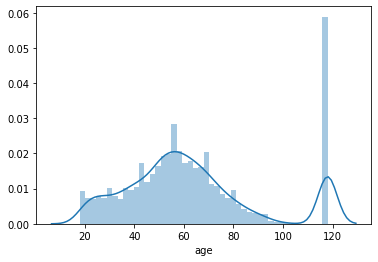

In [261]:
sns.distplot(profile.age).get_figure().savefig("age_base.png")

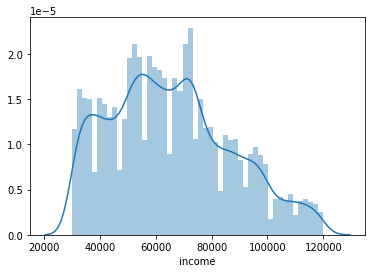

In [262]:
sns.distplot(profile.income,bins=50)

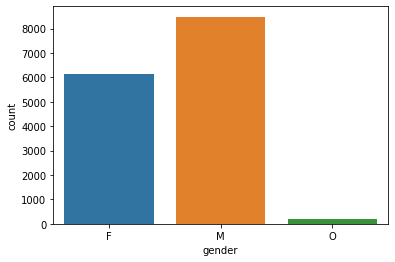

In [263]:
sns.countplot(profile.gender).get_figure().savefig("gender.png")

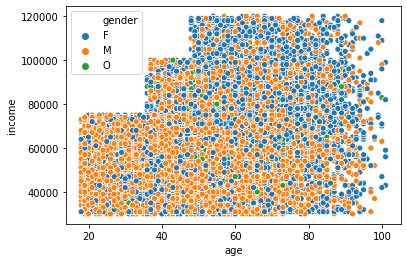

In [264]:
sns.scatterplot(profile.age, profile.income, hue=profile.gender).get_figure().savefig("age_inc_gend.png")

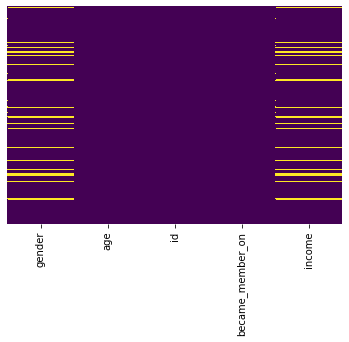

In [265]:
# Find number of missing values

sns.heatmap(profile.isnull(),yticklabels=False,cbar=False,cmap='viridis').get_figure().savefig("missing.png")


This confirms the fact that there's a large number of data missing. The next step will be to identfy how much data is missing and decide what to do with this data. There are two options: remove the data or try to infer the missing data from the existing data

In [266]:
print("The total amount of missing 'gender' data is: ",len(profile[profile["gender"].isnull()]))
print("The total amount of missing 'income' data is: ",len(profile[profile["income"].isnull()]))
print("")
print("The age of the missing 'gender' data is: ",profile[profile["gender"].isnull()]["age"].unique())
print("The age of the missing 'income' data is: ",profile[profile["income"].isnull()]["age"].unique())
print("")
print("The income of the missing 'gender' data is: ",profile[profile["gender"].isnull()]["income"].unique())
print("The gender of the missing 'income' data is: ",profile[profile["income"].isnull()]["gender"].unique())
print("")
print("The percentage of missing data is: ",len(profile[profile["gender"].isnull()])/len(profile)*100)


The total amount of missing 'gender' data is:  2175
The total amount of missing 'income' data is:  2175

The age of the missing 'gender' data is:  [118]
The age of the missing 'income' data is:  [118]

The income of the missing 'gender' data is:  [nan]
The gender of the missing 'income' data is:  [None]

The percentage of missing data is:  12.794117647058822


This confirms that all missing data refers to the same people. This accounts for 13% of the total amount of data. This is a large amount of data. However, this data will be removed because the dataset is a large one that contains a lot of information, so even without this amount of data it will still contain a lot of information. Also, being able to properly predict the agen, income and gender of a customer simply from the day it became a member will be a very difficult task that could add a lot of noise to the data, specially given the little apparent correlation between these features.

In [267]:
# Drop missing data

profile.dropna(inplace=True)

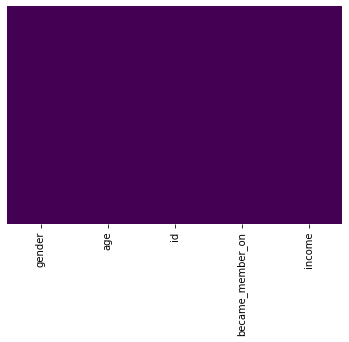

In [268]:
# Confirm all missing data has been removed

sns.heatmap(profile.isnull(),yticklabels=False,cbar=False,cmap='viridis').get_figure().savefig("no_missing.png")

Plot distributions without the missing data

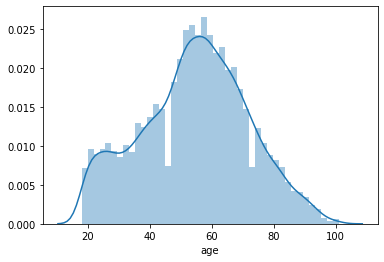

In [269]:
sns.distplot(profile.age).get_figure().savefig("age_clean.png")

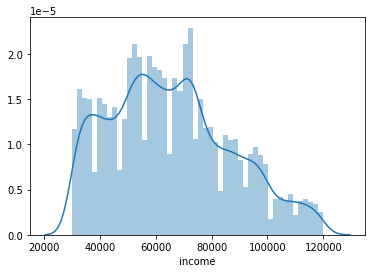

In [270]:
sns.distplot(profile.income,bins=50).get_figure().savefig("income_clean.png")

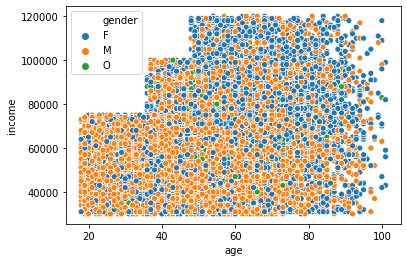

In [271]:
sns.scatterplot(profile.age, profile.income, hue=profile.gender)

In [272]:
# Reset index

profile = profile.reset_index(drop=True)
profile.head()

,gender,age,id,became_member_on,income
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
2,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
3,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0


Convert "gender" column from string "M", "F" or "O" to 0, 1 or 2

In [273]:
def convert_gender(data):
    """ Convert 'gender' data from string M, F or O to 0, 1 or 2
        Args: data - dataset to change
        Outputs: data gender - 0 - Male
                               1 - Female
                               2 - Other
    """
    
    if data["gender"] == "M":
        data["gender"] = 0
    elif data["gender"] == "F":
        data["gender"] = 1
    elif data["gender"] == "O":
        data["gender"] = 2
        
    return data["gender"]

In [274]:
profile["gender"] = profile.apply(lambda row: convert_gender(row),axis=1)

In [275]:
print("The % of males in the profile data is:",round(len(profile.groupby(["gender"]).get_group(0))/len(profile)*100,2),"%")
print("The % of females in the profile data is:",round(len(profile.groupby(["gender"]).get_group(1))/len(profile)*100,2),"%")
print("The % of other in the profile data is:",round(len(profile.groupby(["gender"]).get_group(2))/len(profile)*100,2),"%")

The % of males in the profile data is: 57.23 %
The % of females in the profile data is: 41.34 %
The % of other in the profile data is: 1.43 %


In [276]:
profile.head()

,gender,age,id,became_member_on,income
0,1,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
1,1,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
2,0,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
3,0,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
4,0,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0


In [277]:
# Convert date membership to datetime

profile["became_member_on"] = pd.to_datetime(profile["became_member_on"], format='%Y%m%d')

In [278]:
profile.head()

,gender,age,id,became_member_on,income
0,1,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
1,1,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
2,0,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
3,0,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
4,0,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0


In order to use the "became_member_on" later during the training process, the format of the data will have to be changed from datetime to an actual number. Therefore, the column will be change from an actual date to the number of days the given person has been a member. This will be done by taking the most recent date someone signed up as day 0, so if someone signed up a day before that, they would have been a member for 1 day, and so on. To do so, first we'll have to find the date the last member signed up, and then find the difference between that date and the membership date of the other customers

In [279]:
# Date the newest member signed up

max_sign = profile["became_member_on"].max()

In [280]:
# Find number of days since being a member

profile["days_member"] = max_sign-profile["became_member_on"]
profile["days_member"] = profile["days_member"].dt.days
profile.head()

,gender,age,id,became_member_on,income,days_member
0,1,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,376
1,1,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,443
2,0,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,91
3,0,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,167
4,0,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,257


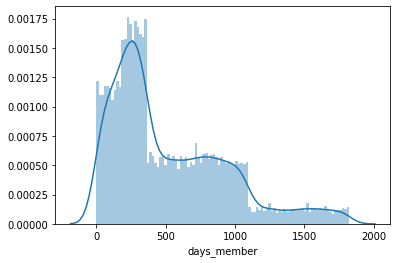

In [281]:
sns.distplot(profile.days_member,bins=100).get_figure().savefig("member_days.png")

In [282]:
# Remove the "became_member_on" column
profile.drop(columns=["became_member_on"],inplace=True)

In [283]:
profile.head()

,gender,age,id,income,days_member
0,1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,376
1,1,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443
2,0,68,e2127556f4f64592b11af22de27a7932,70000.0,91
3,0,65,389bc3fa690240e798340f5a15918d5c,53000.0,167
4,0,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,257


The next step is to create a dictionary that includes the people ids as keys and a unique number identifier as the value of this key

In [284]:
# Create dictionary that assigns people id to numbers

idx_person = {}
count = 0
for idx in profile["id"]:
    idx_person[idx] = count
    count+=1

In [285]:
# Use previously defined function that converts id keys to actual numbers

profile["id"] = profile.apply(lambda row: change_id_porfolio(row, idx_person),axis=1)

In [286]:
# Set the person ID as the dataset key

profile.index = profile["id"]

In [287]:
# Drop the column ID

profile.drop(columns=["id"],inplace=True)

In [288]:
profile

,gender,age,income,days_member
id,,,,
0,1,55,112000.0,376
1,1,75,100000.0,443
2,0,68,70000.0,91
3,0,65,53000.0,167
4,0,58,51000.0,257
...,...,...,...,...
14820,1,45,54000.0,52
14821,0,61,72000.0,13
14822,0,49,73000.0,546


To understand better the dependancies in the data, plot the correlation matrix between the different parameters that define the customers

In [289]:
profile.corr().style.background_gradient(cmap='coolwarm')

,gender,age,income,days_member
gender,1.000000,0.142886,0.209979,-0.022117
age,0.142886,1.000000,0.306703,0.012300
income,0.209979,0.306703,1.000000,0.025769
days_member,-0.022117,0.012300,0.025769,1.000000


This shows that the largest correlation is between the income and age of the customers (this makes sense as typically older people have a larger income than young people and students). Howeber even this correlation is quite small (0.3) which suggests that removing the missing data was a better choice than trying to infer it from the membership date, which is completely uncorrelated to any other parameter.

The below pairplot is a more graphical way of showing the lack of correlation

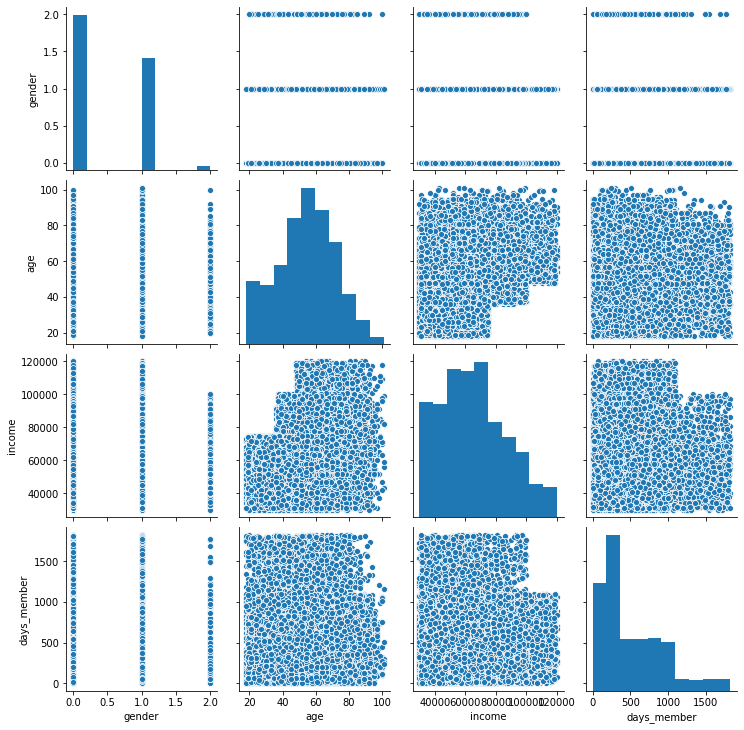

In [290]:
sns.pairplot(profile).savefig("pairplot.png")

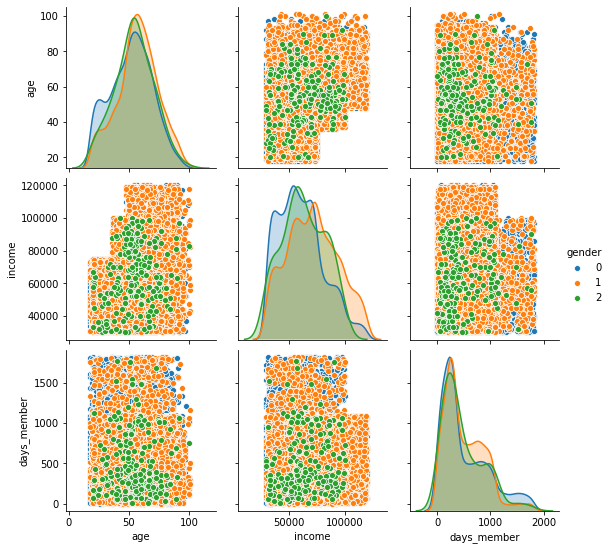

In [291]:
sns.pairplot(profile, hue="gender").savefig("pairplot_gender.png")

In [292]:
# Save data to clean .csv

profile.to_csv("profile_clean.csv")

In [293]:
profile_clean = profile

# Data Processing - Transcript Data

In [294]:
# Read data

transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [295]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


The first thing will be to change the "person" string value by its corresponding number created in the dictionary before. The only difference will be that some of the people doing transactions will be part of the missing data. In that case the key won't be identified. If that is the case, the person id should be set to -1, and then all rows with a -1 in the "person" column will be removed.

In [296]:
def change_person_transcript(data,id_person):
    """ Changes the person hash string id by the numeric id created in a previous dictionary.
        Args: data - dataset to be changed
              id_person - dictionary containing the hash id as key and the unique number as value
        Output - data person - person ID from 0 to 14,824, or -1 if the person is not identified
    """
    
    idx = data["person"]
    try:
        id_new = id_person[idx]
        data["person"] = id_new
    except KeyError:
        data["person"] = -1
    
    return data["person"]


In [297]:
# Apply function

transcript["person"] = transcript.apply(lambda row: change_person_transcript(row, idx_person),axis=1)
transcript.head()

,person,event,value,time
0,1,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,-1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,2,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,-1,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,-1,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [298]:
# Remove people with unidentified ID

transcript = transcript[transcript["person"]!=-1].reset_index(drop=True)

In [299]:
# Find unique events

transcript["event"].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

There are four unique events: receiving an offer, viewing an offer, completing an offer and making a transaction. Therefore the data will be split into four subsets, one for each event, and pre-processed individually.

In [300]:
offer_rec = transcript[transcript["event"]=="offer received"].reset_index(drop=True)
offer_view = transcript[transcript["event"]=="offer viewed"].reset_index(drop=True)
offer_comp = transcript[transcript["event"]=="offer completed"].reset_index(drop=True)
transaction = transcript[transcript["event"]=="transaction"].reset_index(drop=True)

In [301]:
print(offer_rec.shape)
print(offer_view.shape)
print(offer_comp.shape)
print(transaction.shape)

(66501, 4)
(49860, 4)
(32444, 4)
(123957, 4)


The "value" column contains a dictionary with the offer id, in case of an offer being received, viewed or completed, with the reward received if the offer was completed, and a dictionary with the amount spent in the case of a transaction. These dictionaries will be transformed to actual values and columns.

In [302]:
def get_offer_id(data, id_offer):
    """ Convert the value column into the actual offer id from the offer id dictionary.
        Args: data - dataset to be modified
              id_offer - dictionary containing the hash strings of the offer ids as keys and unique numbers as values
        Outputs: data value - unique numeric value of the offer received
    """
    
    offer_id = data["value"]["offer id"]
    id_new = id_offer[offer_id]
    data["value"] = id_new

    return data["value"]

In [303]:
# Convert data 

offer_rec["value"] = offer_rec.apply(lambda row: get_offer_id(row, idx_offers),axis=1)
offer_rec.head()

,person,event,value,time
0,1,offer received,3,0
1,2,offer received,9,0
2,3,offer received,8,0
3,4,offer received,2,0
4,5,offer received,4,0


In [304]:
# Rename column

offer_rec = offer_rec.rename(columns={"value":"offer_id"})
offer_rec

,person,event,offer_id,time
0,1,offer received,3,0
1,2,offer received,9,0
2,3,offer received,8,0
3,4,offer received,2,0
4,5,offer received,4,0
...,...,...,...,...
66496,14787,offer received,0,576
66497,14819,offer received,9,576
66498,14820,offer received,5,576
66499,14823,offer received,0,576


In [305]:
# Apply offer id function and rename

offer_view["value"] = offer_view.apply(lambda row: get_offer_id(row, idx_offers),axis=1)
offer_view = offer_view.rename(columns={"value":"offer_id"})
offer_view

,person,event,offer_id,time
0,3,offer viewed,8,0
1,20,offer viewed,7,0
2,24,offer viewed,1,0
3,28,offer viewed,0,0
4,33,offer viewed,7,0
...,...,...,...,...
49855,13701,offer viewed,7,714
49856,13896,offer viewed,2,714
49857,14328,offer viewed,7,714
49858,14453,offer viewed,2,714


In [306]:
def get_offer_and_reward(data, id_offer):
    """ Convert the value column into the actual offer id from the offer id dictionary, and get the reward given by the offer.
        Args: data - dataset to be modified
              id_offer - dictionary containing the hash strings of the offer ids as keys and unique numbers as values
        Outputs: data value - unique numeric value of the offer received
                 data reward - reward given to customer for completing offer
    """    
    offer_id = data["value"]["offer_id"]
    reward = data["value"]["reward"]
    id_new = id_offer[offer_id]
    data["value"] = id_new
    data["reward"] = reward
    
    return data[["value","reward"]]

In [307]:
# Apply function and rename

offer_comp[["value","reward"]] = offer_comp.apply(lambda row: get_offer_and_reward(row, idx_offers),axis=1)
offer_comp = offer_comp.rename(columns={"value":"offer_id"})
offer_comp.head()

,person,event,offer_id,time,reward
0,39,offer completed,9,0,2
1,123,offer completed,6,0,2
2,144,offer completed,3,0,5
3,259,offer completed,0,0,10
4,273,offer completed,1,0,10


In [308]:
def get_amount(data):
    """ Convert the value column into the actual amount spent by the customer in the transaction.
        Args: data - dataset to be modified
        Outputs: data value - amount spent by customer in transaction
    """
    amount = data["value"]["amount"]
    data["value"] = amount
    
    return data["value"]

In [309]:
# Apply function and rename

transaction["value"] = transaction.apply(lambda row: get_amount(row),axis=1)
transaction = transaction.rename(columns={"value":"Amount"})
transaction.head()

,person,event,Amount,time
0,28,transaction,0.83,0
1,39,transaction,34.56,0
2,45,transaction,13.23,0
3,107,transaction,19.51,0
4,123,transaction,18.97,0


### Merge and Transform 

The end goal of the data processing step is to obtain a dataframe where each row is a unique offer sent to a customer and having columns which include the data about the customer who received the offer (from the profile dataset), information about the offer sent (from the portfolio dataset) and an identifier saying if the offer sent was actually viewed by the customer (using the offer_view dataset), if the offer was acutally used (ie: completed) by the customer (using the offer_comp dataset), and finally the amount spent by the customer in case of completing the received offer.

To do so, first the dataset that contains all offers received by customers will be merged with the portfolio and profile datasets, to include information about the offer and customers. Then, an algorithm will be written to identify if the offer was viewed by the customer, if the offer was completed and if so, how much did the customer spend.

In [310]:
# rename the portfolio offer id and merge it with the offer received dataset

portfolio = portfolio.rename(columns={"id": "offer_id"})
offer_rec = pd.merge(offer_rec, portfolio, on="offer_id")
offer_rec.head()

,person,event,offer_id,time,reward,difficulty,duration,email,mobile,web,social,bogo,info,discount
0,1,offer received,3,0,5,5,168,1,1,1,0,1.0,0.0,0.0
1,18,offer received,3,0,5,5,168,1,1,1,0,1.0,0.0,0.0
2,23,offer received,3,0,5,5,168,1,1,1,0,1.0,0.0,0.0
3,29,offer received,3,0,5,5,168,1,1,1,0,1.0,0.0,0.0
4,32,offer received,3,0,5,5,168,1,1,1,0,1.0,0.0,0.0


In [311]:
# Merge the offer received data with the customer profile data

profile_clean["person"] = profile_clean.index
offer_rec = pd.merge(offer_rec, profile_clean, on='person')
offer_rec.head()

,person,event,offer_id,time,reward,difficulty,duration,email,mobile,web,social,bogo,info,discount,gender,age,income,days_member
0,1,offer received,3,0,5,5,168,1,1,1,0,1.0,0.0,0.0,1,75,100000.0,443
1,1,offer received,8,504,5,5,120,1,1,1,1,1.0,0.0,0.0,1,75,100000.0,443
2,1,offer received,0,408,10,10,168,1,1,0,1,1.0,0.0,0.0,1,75,100000.0,443
3,1,offer received,7,168,0,0,72,1,1,0,1,0.0,1.0,0.0,1,75,100000.0,443
4,18,offer received,3,0,5,5,168,1,1,1,0,1.0,0.0,0.0,0,59,41000.0,1282


In [312]:
def check_offer_viewed(receive,view):
    """ Check if the offer received by the customer has been viewed.
        Args: receive - dataset that includes the offers received by customers
              view - dataset that includes the offers viewed by customers
        Output: receive Viewed - 0 or 1 depending on if the customer viewed the offer they received
    """
    
    person = receive["person"] 
    offer_id = receive["offer_id"] 
    offer_rec = receive["time"] # starting time when the customer received the offer
    offer_duration = receive["duration"] # duration of offer received
    
    # Selects all viewed offers by the given person with the given offer id within the time of validity of the offer
    viewed = view[(view["person"]==person)&(view["offer_id"]==offer_id)&(
        view.time.between(offer_rec,offer_rec+offer_duration))] 
    
    if len(viewed)>0:
        receive["Viewed"] = 1 # Customer viewed the received offer
    else:
        receive["Viewed"] = 0
    
    return receive["Viewed"]

In [313]:
# Apply function

offer_rec["Viewed"] = np.zeros(len(offer_rec))
offer_rec["Viewed"] = offer_rec.apply(lambda row: check_offer_viewed(row,offer_view),axis=1)
offer_rec.head()

,person,event,offer_id,time,reward,difficulty,duration,email,mobile,web,social,bogo,info,discount,gender,age,income,days_member,Viewed
0,1,offer received,3,0,5,5,168,1,1,1,0,1.0,0.0,0.0,1,75,100000.0,443,1
1,1,offer received,8,504,5,5,120,1,1,1,1,1.0,0.0,0.0,1,75,100000.0,443,1
2,1,offer received,0,408,10,10,168,1,1,0,1,1.0,0.0,0.0,1,75,100000.0,443,1
3,1,offer received,7,168,0,0,72,1,1,0,1,0.0,1.0,0.0,1,75,100000.0,443,1
4,18,offer received,3,0,5,5,168,1,1,1,0,1.0,0.0,0.0,0,59,41000.0,1282,0


In [314]:
def check_offer_complete(receive,view,complete):
    """ Check if the offer received by the customer has been used/completed. 
        Args: receive - dataset that includes the offers received by customers
              view - dataset that includes the offers viewed by customers
              complete - dataset that includes the offers completed by customers
        Output: receive Completed - 0 or 1 depending on if the customer completed the offer they received
    """    
    person = receive["person"]
    offer_id = receive["offer_id"]
    offer_rec = receive["time"]
    offer_duration = receive["duration"]
    
    viewed = view[(view["person"]==person)&(view["offer_id"]==offer_id)&(
        view.time.between(offer_rec,offer_rec+offer_duration))]
    
    if len(viewed)>0:
        
        #If the customer viewed the received offer, find out the date when this was viewed
        date_viewed = viewed["time"].iloc[0]
        
    # Selects all completed offers by the given person with the given offer id within the time of validity of the offer
    completed = complete[(complete["person"]==person)&(complete["offer_id"]==offer_id)&(
        complete.time.between(offer_rec,offer_rec+offer_duration))]
    
    if len(completed)>0:
        
        #If the customer completed the received offer, find out the date when this was completed
        date_completed = completed["time"].iloc[0]
        
        if len(viewed)>0: # If the customer viewed and completed the offer
        
            if date_completed<date_viewed: # If the customer completed the offer before viewing it, the customer actually 
                                            # didn't view the offer, so "Viewed" has to be changed to 0. Therefore "Completed"
                                            # will be set to 2 to identify the "false-viewed" cases
                receive["Completed"] = 2
                
            elif date_completed>=date_viewed:
                
                receive["Completed"] = 1
        else:
            
            receive["Completed"] = 1
    else:
        
        receive["Completed"]=0
    
    return receive["Completed"]

In [315]:
# Apply function

offer_rec["Completed"] = np.zeros(len(offer_rec))
offer_rec["Completed"] = offer_rec.apply(lambda row: check_offer_complete(row,offer_view,offer_comp),axis=1)
offer_rec.head()

,person,event,offer_id,time,reward,difficulty,duration,email,mobile,web,social,bogo,info,discount,gender,age,income,days_member,Viewed,Completed
0,1,offer received,3,0,5,5,168,1,1,1,0,1.0,0.0,0.0,1,75,100000.0,443,1,1
1,1,offer received,8,504,5,5,120,1,1,1,1,1.0,0.0,0.0,1,75,100000.0,443,1,2
2,1,offer received,0,408,10,10,168,1,1,0,1,1.0,0.0,0.0,1,75,100000.0,443,1,1
3,1,offer received,7,168,0,0,72,1,1,0,1,0.0,1.0,0.0,1,75,100000.0,443,1,0
4,18,offer received,3,0,5,5,168,1,1,1,0,1.0,0.0,0.0,0,59,41000.0,1282,0,0


In [316]:
def remove_false_viewed(data):
    """ Identify the false viewed offers anc convert them to 0.
        Args: data - dataset to be modified
        Output: data viewed - if offer was viewed or not by customer
                data completed - if offer was completed or not by customer"""
    
    if data["Completed"] ==2: # False viewed
        data["Viewed"] = 0
        data["Completed"] = 1
        
    return data[["Viewed","Completed"]]

In [317]:
# Apply function

offer_rec[["Viewed","Completed"]] = offer_rec.apply(lambda row: remove_false_viewed(row),axis=1)
offer_rec.head()

,person,event,offer_id,time,reward,difficulty,duration,email,mobile,web,social,bogo,info,discount,gender,age,income,days_member,Viewed,Completed
0,1,offer received,3,0,5,5,168,1,1,1,0,1.0,0.0,0.0,1,75,100000.0,443,1,1
1,1,offer received,8,504,5,5,120,1,1,1,1,1.0,0.0,0.0,1,75,100000.0,443,0,1
2,1,offer received,0,408,10,10,168,1,1,0,1,1.0,0.0,0.0,1,75,100000.0,443,1,1
3,1,offer received,7,168,0,0,72,1,1,0,1,0.0,1.0,0.0,1,75,100000.0,443,1,0
4,18,offer received,3,0,5,5,168,1,1,1,0,1.0,0.0,0.0,0,59,41000.0,1282,0,0


The next step is to check if the offer received completed with a transaction, and if so, what was the value of the transaction

In [318]:
def check_offer_transaction(receive,complete,transaction):
    """ Checks if the offer received by the customer was completed, and finds the transaction made to complete the offer
        and the value of such transaction
        Args: receive - dataset containing information about the offer received
              complete - dataset containing information about the offer completed
              transaction - dataset containing information about the transactions made
        Output: receive amount - amount spent by the customer that received the amount (either 0 or a float > 0)
    """
    
    person = receive["person"]
    offer_id = receive["offer_id"]
    offer_rec = receive["time"]
    offer_duration = receive["duration"]
    
    completed = complete[(complete["person"]==person)&(complete["offer_id"]==offer_id)&(
        complete.time.between(offer_rec,offer_rec+offer_duration))]
    
    # If the offer was completed
    if len(completed)>0:
        
        date_completed = completed["time"].iloc[0] # Find date of offer completed
        
        numb_completed = len(complete[(complete["person"]==person)&(
        complete["time"]==date_completed)]) # Find number of offers completed by customer that date
        
        # Find amount spent by customer when completing the offer. A customer can complete more than one offer with just one transaction
        # This is taken into account by splitting the total amount spent over the offers completed
        amount = transaction[(transaction["person"]==person)&(
            transaction["time"]==date_completed)]["Amount"].iloc[0]/numb_completed                       
    
        receive["Amount"] = amount

    else:
        receive["Amount"] = 0
    
    return receive["Amount"]

In [319]:
# Apply function

offer_rec["Amount"] = np.zeros(len(offer_rec))
offer_rec["Amount"] = offer_rec.apply(lambda row: check_offer_transaction(row,offer_comp,transaction),axis=1)
offer_rec.head()

,person,event,offer_id,time,reward,difficulty,duration,email,mobile,web,...,bogo,info,discount,gender,age,income,days_member,Viewed,Completed,Amount
0,1,offer received,3,0,5,5,168,1,1,1,...,1.0,0.0,0.0,1,75,100000.0,443,1,1,19.89
1,1,offer received,8,504,5,5,120,1,1,1,...,1.0,0.0,0.0,1,75,100000.0,443,0,1,10.86
2,1,offer received,0,408,10,10,168,1,1,0,...,1.0,0.0,0.0,1,75,100000.0,443,1,1,10.86
3,1,offer received,7,168,0,0,72,1,1,0,...,0.0,1.0,0.0,1,75,100000.0,443,1,0,0.00
4,18,offer received,3,0,5,5,168,1,1,1,...,1.0,0.0,0.0,0,59,41000.0,1282,0,0,0.00


In [320]:
# def remove_transaction(receive,complete,transaction):
    
#     if receive["Completed"]==1:
        
#         person = receive["person"]
#         offer_id = receive["offer_id"]
#         offer_rec = receive["time"]
#         offer_duration = receive["duration"]
    
#         completed = complete[(complete["person"]==person)&(complete["offer_id"]==offer_id)&(
#         complete.time.between(offer_rec,offer_rec+offer_duration))]
        
#         date_completed = completed["time"].iloc[0]
#         idx_completed = completed.index[0]

#         #completed = complete[(complete["person"]==person)&(complete["offer_id"]==offer_id)&(
#         #complete["time"]==date_completed)]
        
#         completed_same_time = complete[(complete["person"]==person)&(
#         complete["time"]==date_completed)]
        
#         numb_completed = len(completed_same_time)
        
#         complete.drop(index=idx_completed, inplace=True)

#         if numb_completed == 1:
#             idx_amount = transaction[(transaction["person"]==person)&(
#                 transaction["time"]==date_completed)].index[0]
    
#             transaction.drop(index=idx_amount, inplace=True)
    
#     return complete, transaction

In [321]:
# transaction_drop = transcript[transcript["event"]=="transaction"].reset_index(drop=True)
# completed_drop = transcript[transcript["event"]=="offer completed"].reset_index(drop=True)

In [322]:
# completed_drop,transaction_drop  = offer_rec.apply(lambda row: remove_transaction(
#     row,completed_drop,transaction_drop),axis=1)

The informational offer types aren't linked to any transaction in particular, so initially they don't appear as "Completed". In order to identify if they were used or not, an algorithm is written to identify if the customer that received the informational offer viewed the offer and made transaction before the expiry date. If this is the case the offer will be considered as "Completed".

To do so, first the transactions that don't belong to offers that were completed have to be identified.

In [323]:
all_trans = pd.merge(offer_comp, transaction, on=["person","time"],how="right")
transaction_other = all_trans[pd.isnull(all_trans['event_x'])].reset_index(drop=True)
transaction_other = transaction_other[["person","time","Amount"]]
transaction_other

,person,time,Amount
0,28,0,0.83
1,45,0,13.23
2,107,0,19.51
3,219,0,18.59
4,333,0,36.19
...,...,...,...
94371,14770,714,43.58
94372,14791,714,1.59
94373,14796,714,9.53
94374,14809,714,3.61


In [324]:
def check_offer_complete(receive,view,transaction):
    """ Checks which informational offers received by the customer were viewed and completed.
        Args: receive - dataset that includes the offers received
              view - dataset that includes the offers viewed
              transaction - dataset that includes the transactions done by customers
        Outputs: receive completed - describes if the offer received by the customer was completed (0 or 1)
                 receive amount - descibres the amount spent by the customer 
    """
    
    if receive["info"]==1: # Select only informational offers
    
        person = receive["person"]
        offer_id = receive["offer_id"]
        offer_rec = receive["time"]
        offer_duration = receive["duration"]

        if receive["Viewed"]==1: # If the offer was viewed
            
            viewed = view[(view["person"]==person)&(view["offer_id"]==offer_id)&(
                view.time.between(offer_rec,offer_rec+offer_duration))] # Date when the offer was viewed

            date_viewed = viewed["time"].iloc[0]
            
            # Find out how much did the customer spent between viewing the offer and the end of its validity
            amount = transaction[(transaction["person"]==person)&(transaction["time"].between(
                date_viewed,offer_rec+offer_duration))]["Amount"].sum()
            
            if amount > 0:
                
                receive["Completed"] = 1 # If the customer spent something, mark the offer as Completed
                receive["Amount"] = amount
        else:
            
            # Finds out how much did the customer spend despite not viewing the offer
            amount = transaction[(transaction["person"]==person)&(transaction["time"].between(
                offer_rec,offer_rec+offer_duration))]["Amount"].sum()
            
            receive["Amount"] = amount

    return receive[["Completed","Amount"]]

In [325]:
# Apply function

offer_rec[["Completed","Amount"]] = offer_rec.apply(
    lambda row: check_offer_complete(row,offer_view,transaction_other),axis=1)
offer_rec.head()

,person,event,offer_id,time,reward,difficulty,duration,email,mobile,web,...,bogo,info,discount,gender,age,income,days_member,Viewed,Completed,Amount
0,1,offer received,3,0,5,5,168,1,1,1,...,1.0,0.0,0.0,1,75,100000.0,443,1,1,19.89
1,1,offer received,8,504,5,5,120,1,1,1,...,1.0,0.0,0.0,1,75,100000.0,443,0,1,10.86
2,1,offer received,0,408,10,10,168,1,1,0,...,1.0,0.0,0.0,1,75,100000.0,443,1,1,10.86
3,1,offer received,7,168,0,0,72,1,1,0,...,0.0,1.0,0.0,1,75,100000.0,443,1,1,49.39
4,18,offer received,3,0,5,5,168,1,1,1,...,1.0,0.0,0.0,0,59,41000.0,1282,0,0,0.00


In [344]:
info_offers = offer_rec[(offer_rec["info"]==1)]
info_offers

,person,offer_id,reward,difficulty,duration,email,mobile,web,social,bogo,...,age,income,days_member,Viewed,Completed,Amount,V_C,nV_C,V_nC,nV_nC
3,1,7,0,0,72,1,1,0,1,0.0,...,75,100000.0,443,1,1,49.39,1.0,0.0,0.0,0.0
8,18,7,0,0,72,1,1,0,1,0.0,...,59,41000.0,1282,1,1,7.72,1.0,0.0,0.0,0.0
9,18,7,0,0,72,1,1,0,1,0.0,...,59,41000.0,1282,1,1,2.32,1.0,0.0,0.0,0.0
15,23,7,0,0,72,1,1,0,1,0.0,...,40,33000.0,747,1,0,0.00,0.0,0.0,1.0,0.0
17,29,2,0,0,96,1,1,1,0,0.0,...,45,33000.0,19,1,1,11.25,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66496,12113,7,0,0,72,1,1,0,1,0.0,...,52,84000.0,715,1,0,0.00,0.0,0.0,1.0,0.0
66497,12113,7,0,0,72,1,1,0,1,0.0,...,52,84000.0,715,1,0,0.00,0.0,0.0,1.0,0.0
66498,12726,7,0,0,72,1,1,0,1,0.0,...,63,61000.0,572,1,1,8.76,1.0,0.0,0.0,0.0
66499,12726,7,0,0,72,1,1,0,1,0.0,...,63,61000.0,572,1,1,9.10,1.0,0.0,0.0,0.0


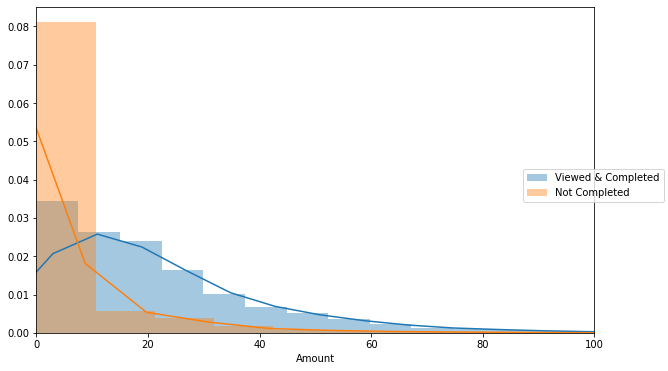

In [462]:
fig = plt.figure(figsize=(10,6))
sns.distplot(info_offers[info_offers["V_C"]==1].Amount,bins=100,label="Viewed & Completed")
sns.distplot(info_offers[info_offers["V_C"]==0].Amount,bins=100,label="Not Completed")
plt.xlim(0, 100)
fig.legend(loc="center right")
fig.savefig("amount_info.png")


In [391]:
offer_rec[(offer_rec["info"]==1)&(offer_rec["Completed"]==0)]["Amount"].mean()

5.222015905530787

In [438]:
offer_rec[(offer_rec["info"]==1)&(offer_rec["Completed"]==1)]["Amount"].mean()#/offer_rec[(offer_rec["info"]==1)&(offer_rec["Completed"]==0)]["Amount"].mean()

23.752585482903417

In [329]:
offer_rec.drop(columns=["event","time"],inplace=True)

In [330]:
offer_rec.head()

,person,offer_id,reward,difficulty,duration,email,mobile,web,social,bogo,info,discount,gender,age,income,days_member,Viewed,Completed,Amount
0,1,3,5,5,168,1,1,1,0,1.0,0.0,0.0,1,75,100000.0,443,1,1,19.89
1,1,8,5,5,120,1,1,1,1,1.0,0.0,0.0,1,75,100000.0,443,0,1,10.86
2,1,0,10,10,168,1,1,0,1,1.0,0.0,0.0,1,75,100000.0,443,1,1,10.86
3,1,7,0,0,72,1,1,0,1,0.0,1.0,0.0,1,75,100000.0,443,1,1,49.39
4,18,3,5,5,168,1,1,1,0,1.0,0.0,0.0,0,59,41000.0,1282,0,0,0.00


The final step in the data pre-processing is to create four one-hot encoded columns with the four possible outcomes:
1. Offer Viewed and Completed
2. Offer Not Viewed and Completed
3. Offer Viewed but Not Completed
4. Offer Not Viewed and Not Completed

In [335]:
def view_and_complete(data):
    """ Binary classification of the four possible outcomes when receiving an offer
        Args: data - dataset to be modified
        Outputs: data V_C - offer viewed and completed (0 or 1)
                 data nV_C - offer not viewed but completed (0 or 1)
                 data V_nC - offer viewed but not completed (0 or 1)
                 data nV_nC - offer not viewed and not completed (0 or 1)
    
    """
    if (data["Viewed"] == 1) & (data["Completed"] == 1):
        
        data["V_C"] = 1
        
    elif (data["Viewed"] == 0) & (data["Completed"] == 1):
        
        data["nV_C"] = 1
        
    elif (data["Viewed"] == 1) & (data["Completed"] == 0):
        
        data["V_nC"] = 1
        
    elif (data["Viewed"] == 0) & (data["Completed"] == 0):
        
        data["nV_nC"] = 1
        
        
    return data[["V_C","nV_C","V_nC","nV_nC"]]

In [334]:
# Apply function

offer_rec["V_C"] = np.zeros(len(offer_rec))
offer_rec["nV_C"] = np.zeros(len(offer_rec))
offer_rec["V_nC"] = np.zeros(len(offer_rec))
offer_rec["nV_nC"] = np.zeros(len(offer_rec))

offer_rec[["V_C","nV_C","V_nC","nV_nC"]] = offer_rec.apply(lambda row: view_and_complete(row),axis=1)
offer_rec

,person,offer_id,reward,difficulty,duration,email,mobile,web,social,bogo,...,age,income,days_member,Viewed,Completed,Amount,V_C,nV_C,V_nC,nV_nC
0,1,3,5,5,168,1,1,1,0,1.0,...,75,100000.0,443,1,1,19.89,1.0,0.0,0.0,0.0
1,1,8,5,5,120,1,1,1,1,1.0,...,75,100000.0,443,0,1,10.86,0.0,1.0,0.0,0.0
2,1,0,10,10,168,1,1,0,1,1.0,...,75,100000.0,443,1,1,10.86,1.0,0.0,0.0,0.0
3,1,7,0,0,72,1,1,0,1,0.0,...,75,100000.0,443,1,1,49.39,1.0,0.0,0.0,0.0
4,18,3,5,5,168,1,1,1,0,1.0,...,59,41000.0,1282,0,0,0.00,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66496,12113,7,0,0,72,1,1,0,1,0.0,...,52,84000.0,715,1,0,0.00,0.0,0.0,1.0,0.0
66497,12113,7,0,0,72,1,1,0,1,0.0,...,52,84000.0,715,1,0,0.00,0.0,0.0,1.0,0.0
66498,12726,7,0,0,72,1,1,0,1,0.0,...,63,61000.0,572,1,1,8.76,1.0,0.0,0.0,0.0
66499,12726,7,0,0,72,1,1,0,1,0.0,...,63,61000.0,572,1,1,9.10,1.0,0.0,0.0,0.0


In [336]:
# Save data

offer_rec.to_csv("Final_preprocessed_data.csv",index=False)

In [2]:
final_data = pd.read_csv("Final_preprocessed_data.csv")
#final_data.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
final_data# = offer_rec

,person,offer_id,reward,difficulty,duration,email,mobile,web,social,bogo,...,age,income,days_member,Viewed,Completed,Amount,V_C,nV_C,V_nC,nV_nC
0,1,3,5,5,168,1,1,1,0,1.0,...,75,100000.0,443,1,1,19.89,1.0,0.0,0.0,0.0
1,1,8,5,5,120,1,1,1,1,1.0,...,75,100000.0,443,0,1,10.86,0.0,1.0,0.0,0.0
2,1,0,10,10,168,1,1,0,1,1.0,...,75,100000.0,443,1,1,10.86,1.0,0.0,0.0,0.0
3,1,7,0,0,72,1,1,0,1,0.0,...,75,100000.0,443,1,1,49.39,1.0,0.0,0.0,0.0
4,18,3,5,5,168,1,1,1,0,1.0,...,59,41000.0,1282,0,0,0.00,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66496,12113,7,0,0,72,1,1,0,1,0.0,...,52,84000.0,715,1,0,0.00,0.0,0.0,1.0,0.0
66497,12113,7,0,0,72,1,1,0,1,0.0,...,52,84000.0,715,1,0,0.00,0.0,0.0,1.0,0.0
66498,12726,7,0,0,72,1,1,0,1,0.0,...,63,61000.0,572,1,1,8.76,1.0,0.0,0.0,0.0
66499,12726,7,0,0,72,1,1,0,1,0.0,...,63,61000.0,572,1,1,9.10,1.0,0.0,0.0,0.0


In [4]:
# Group data by each individual customer

final_data_person = final_data.groupby("person").mean()
final_data_person

,offer_id,reward,difficulty,duration,email,mobile,web,social,bogo,info,...,age,income,days_member,Viewed,Completed,Amount,V_C,nV_C,V_nC,nV_nC
person,,,,,,,,,,,,,,,,,,,,,
0,2.500000,2.500000,2.500000,132.0,1.0,1.000000,1.000000,0.000000,0.500000,0.500000,...,55.0,112000.0,376.0,0.000000,0.500000,11.610000,0.000000,0.500000,0.000000,0.500000
1,4.500000,5.000000,5.000000,132.0,1.0,1.000000,0.500000,0.750000,0.750000,0.250000,...,75.0,100000.0,443.0,0.750000,1.000000,22.750000,0.750000,0.250000,0.000000,0.000000
2,5.000000,2.250000,6.250000,168.0,1.0,1.000000,1.000000,0.250000,0.250000,0.250000,...,68.0,70000.0,91.0,0.750000,0.500000,4.605000,0.500000,0.000000,0.250000,0.250000
3,6.166667,4.000000,6.666667,164.0,1.0,1.000000,1.000000,0.500000,0.666667,0.000000,...,65.0,53000.0,167.0,1.000000,0.833333,6.071667,0.833333,0.000000,0.166667,0.000000
4,4.333333,1.666667,5.666667,168.0,1.0,1.000000,1.000000,0.666667,0.000000,0.333333,...,58.0,51000.0,257.0,0.666667,0.333333,2.380000,0.333333,0.000000,0.333333,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14820,4.333333,4.333333,5.666667,120.0,1.0,1.000000,0.666667,1.000000,0.333333,0.333333,...,45.0,54000.0,52.0,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
14821,4.000000,1.666667,1.666667,112.0,1.0,1.000000,0.666667,0.333333,0.333333,0.666667,...,61.0,72000.0,13.0,0.333333,0.333333,2.153333,0.000000,0.333333,0.333333,0.333333
14822,4.333333,1.666667,6.666667,136.0,1.0,0.666667,0.666667,0.333333,0.000000,0.666667,...,49.0,73000.0,546.0,0.333333,0.333333,3.656667,0.333333,0.000000,0.000000,0.666667


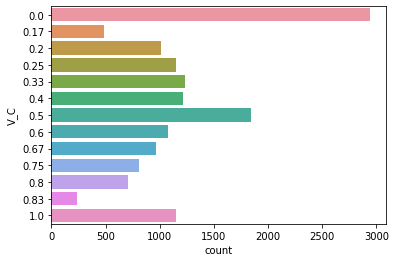

In [5]:
# Plot the effectiveness distribution for all customers

sns.countplot(y=round(final_data_person.V_C,2)
             ).get_figure().savefig("comp_person.png")

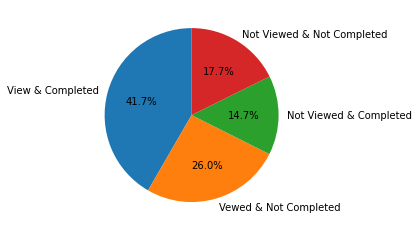

In [6]:
# Analyse the offer effectiveness

V_C = final_data[final_data["V_C"]==1].reset_index(drop=True)
V_nC = final_data[final_data["V_nC"]==1].reset_index(drop=True)
nV_C = final_data[final_data["nV_C"]==1].reset_index(drop=True)
nV_nC = final_data[final_data["nV_nC"]==1].reset_index(drop=True)

labels = ["View & Completed","Vewed & Not Completed","Not Viewed & Completed","Not Viewed & Not Completed"]
plt.pie([len(V_C),len(V_nC),len(nV_C),len(nV_nC)],labels=labels,autopct='%1.1f%%', startangle=90)
plt.savefig("pie_offers.png")

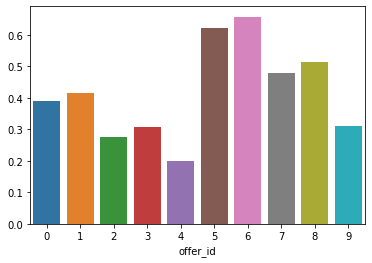

In [7]:
x = final_data.groupby("offer_id").mean().V_C.index
y = final_data.groupby("offer_id").mean().V_C.values
sns.barplot(x,y)

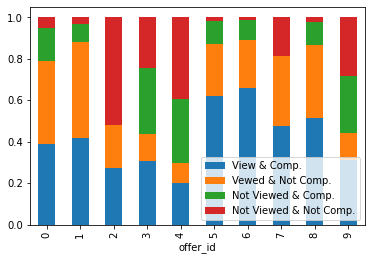

In [8]:
# Analyse the offer effectiveness per offer

avg = final_data.groupby("offer_id").mean()
#avg.plot(kind="bar",x=avg.index,y=avg.V_C.values)
ax = avg[['V_C','V_nC','nV_C','nV_nC']].plot(kind='bar', stacked=True,)
ax.legend(["View & Comp.","Vewed & Not Comp.","Not Viewed & Comp.","Not Viewed & Not Comp."],loc="best")
ax.figure.savefig("offers_detailed.png")

In [9]:
# Analyse the correlation between parameters

corr = final_data.corr()
corr_p = final_data_person.corr()


In [10]:
corr.style.background_gradient(cmap='coolwarm')

/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/pandas/io/formats/style.py:1089: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/pandas/io/formats/style.py:1090: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


,person,offer_id,reward,difficulty,duration,email,mobile,web,social,bogo,info,discount,gender,age,income,days_member,Viewed,Completed,Amount,V_C,nV_C,V_nC,nV_nC
person,1.000000,0.004336,-0.003453,-0.003486,-0.004264,nan,0.000699,-0.006842,-0.002835,-0.000914,0.004613,-0.002852,-0.008872,-0.011697,-0.010807,-0.009717,0.002577,-0.001513,-0.001167,0.006765,-0.011536,-0.004857,0.007547
offer_id,0.004336,1.000000,-0.604637,-0.103124,0.007746,nan,0.057732,0.175232,0.000294,-0.428066,0.000625,0.427215,0.000151,0.001160,0.001494,-0.005794,0.013088,0.100478,0.000458,0.087416,0.019021,-0.084332,-0.033707
reward,-0.003453,-0.604637,1.000000,0.465176,0.161964,nan,-0.079089,-0.120241,0.286961,0.791978,-0.617818,-0.287104,-0.001878,-0.004319,0.001971,0.003557,0.098666,0.029395,-0.010797,-0.032849,0.086888,0.142264,-0.201659
difficulty,-0.003486,-0.103124,0.465176,1.000000,0.809257,nan,-0.742892,0.243572,-0.156460,-0.031252,-0.695277,0.598690,-0.001961,-0.004088,-0.000858,0.001820,-0.136608,0.074075,-0.006668,-0.070850,0.202353,-0.066152,-0.020276
duration,-0.004264,0.007746,0.161964,0.809257,1.000000,nan,-0.531442,0.340997,-0.185837,-0.184856,-0.682049,0.741376,-0.003802,-0.003150,-0.002406,0.001714,-0.121591,0.147131,0.000074,0.004612,0.199614,-0.134983,-0.036150
email,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mobile,0.000699,0.057732,-0.079089,-0.742892,-0.531442,nan,1.000000,-0.167925,0.409566,0.273344,0.167720,-0.410015,-0.003504,-0.000239,0.002979,-0.001643,0.270194,0.039086,0.005327,0.147965,-0.151233,0.122035,-0.191013
web,-0.006842,0.175232,-0.120241,0.243572,0.340997,nan,-0.167925,1.000000,-0.410007,-0.104735,-0.373582,0.409558,-0.003878,-0.000266,-0.004473,-0.001900,-0.135147,0.051610,-0.004018,-0.017012,0.095952,-0.125136,0.076692
social,-0.002835,0.000294,0.286961,-0.156460,-0.185837,nan,0.409566,-0.410007,1.000000,0.248637,-0.101023,-0.165987,-0.003187,-0.000272,0.004771,-0.003820,0.459821,0.105967,0.009608,0.239136,-0.184487,0.221933,-0.392720
bogo,-0.000914,-0.428066,0.791978,-0.031252,-0.184856,nan,0.273344,-0.104735,0.248637,1.000000,-0.407434,-0.666670,-0.000251,-0.001719,0.001996,0.003498,0.116528,0.018707,-0.012594,-0.017104,0.050005,0.143626,-0.189332


# Model

Split the data between X values (features) and y values (labels)

In [11]:
cols = final_data.columns.values
cols

array(['person', 'offer_id', 'reward', 'difficulty', 'duration', 'email',
       'mobile', 'web', 'social', 'bogo', 'info', 'discount', 'gender',
       'age', 'income', 'days_member', 'Viewed', 'Completed', 'Amount',
       'V_C', 'nV_C', 'V_nC', 'nV_nC'], dtype=object)

In [12]:
final_data.head()

,person,offer_id,reward,difficulty,duration,email,mobile,web,social,bogo,...,age,income,days_member,Viewed,Completed,Amount,V_C,nV_C,V_nC,nV_nC
0,1,3,5,5,168,1,1,1,0,1.0,...,75,100000.0,443,1,1,19.89,1.0,0.0,0.0,0.0
1,1,8,5,5,120,1,1,1,1,1.0,...,75,100000.0,443,0,1,10.86,0.0,1.0,0.0,0.0
2,1,0,10,10,168,1,1,0,1,1.0,...,75,100000.0,443,1,1,10.86,1.0,0.0,0.0,0.0
3,1,7,0,0,72,1,1,0,1,0.0,...,75,100000.0,443,1,1,49.39,1.0,0.0,0.0,0.0
4,18,3,5,5,168,1,1,1,0,1.0,...,59,41000.0,1282,0,0,0.00,0.0,0.0,0.0,1.0


In [13]:
# Select features for training

class_X = final_data[['person','offer_id', 'reward', 'difficulty', 'duration', 'email',
       'mobile', 'web', 'social',  'bogo',
       'info', 'discount', 'gender', 'age', 'income', 'days_member']]
class_X.head()

,person,offer_id,reward,difficulty,duration,email,mobile,web,social,bogo,info,discount,gender,age,income,days_member
0,1,3,5,5,168,1,1,1,0,1.0,0.0,0.0,1,75,100000.0,443
1,1,8,5,5,120,1,1,1,1,1.0,0.0,0.0,1,75,100000.0,443
2,1,0,10,10,168,1,1,0,1,1.0,0.0,0.0,1,75,100000.0,443
3,1,7,0,0,72,1,1,0,1,0.0,1.0,0.0,1,75,100000.0,443
4,18,3,5,5,168,1,1,1,0,1.0,0.0,0.0,0,59,41000.0,1282


In [96]:
# Select labels for training

class_y = final_data[['V_C', 'nV_C', 'V_nC', 'nV_nC']]
class_y

,V_C,nV_C,V_nC,nV_nC
0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0
...,...,...,...,...
66496,0.0,0.0,1.0,0.0
66497,0.0,0.0,1.0,0.0
66498,1.0,0.0,0.0,0.0
66499,1.0,0.0,0.0,0.0


In [742]:
def make_multiclass(data):
    """ Create a unique column to identify the class number.
        Args: data - dataset to modify
        Outputs - data label - Value of lable from 0 to 3 depending on the class of the data"""
    
    if data["V_C"] == 1:
        data["Label"] = 0
    elif data["nV_C"] == 1:
        data["Label"] = 1
    elif data["V_nC"] == 1:
        data["Label"] = 2
    elif data["nV_nC"] == 1:
        data["Label"] = 3
        
    return data["Label"]

In [16]:
# Apply function and create label

class_y["Label"] = np.zeros(len(class_y))
class_y["Label"] = class_y.apply(lambda row: make_multiclass(row),axis=1)
class_y

/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,V_C,nV_C,V_nC,nV_nC,Label
0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,3.0
...,...,...,...,...,...
66496,0.0,0.0,1.0,0.0,2.0
66497,0.0,0.0,1.0,0.0,2.0
66498,1.0,0.0,0.0,0.0,0.0
66499,1.0,0.0,0.0,0.0,0.0


In [19]:
# Created a dataframe with just one column, being the final label

class_Y = class_y.Label
class_Y_df = pd.DataFrame(class_Y)
class_Y_df

,Label
0,0.0
1,1.0
2,0.0
3,0.0
4,3.0
...,...
66496,2.0
66497,2.0
66498,0.0
66499,0.0


The first step in the training process is to split the dataset into test, train and validation. The data is normalised using scikit-learn’s MinMaxScaler class. This is done to make sure that all data is within the same order of magnitude. Furthermore, a VarianceThreshold algorithm is used to remove the features with no variance, thus making the training process faster. 

#### Imports for Training

In [795]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError, CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support

from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,multilabel_confusion_matrix

In [754]:
# Split test train data

#X_train, X_test, y_train, y_test = train_test_split(class_X, class_Y_df.to_numpy(), test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(class_X, pd.DataFrame(class_y["V_C"]).to_numpy(), test_size=0.1, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# Define data pre-processing scalers

scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
variance = VarianceThreshold()

# Apply scaling

X_train = scaler.fit_transform(X_train)
#y_train = y_scaler.fit_transform(y_train)
X_train = variance.fit_transform(X_train)

X_test = scaler.transform(X_test)
#y_test = y_scaler.transform(y_test)
X_test = variance.transform(X_test)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(59850, 16)
(6651, 16)
(59850, 1)
(6651, 1)
(59850, 15)
(6651, 15)
(59850, 1)
(6651, 1)


## Logistic Regression

In [750]:
# Apply logistic regression model

# Train model
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

# Predict values
y_pred = clf.predict(X_test)
y_pred

/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


array([1., 0., 1., ..., 0., 1., 1.])

In [751]:
# Print metrics of interest

print(accuracy_score(y_test,y_pred))
print("")
print(confusion_matrix(y_test,y_pred))
print("")
print(classification_report(y_test,y_pred))

0.6552398135618704

[[3045  846]
 [1447 1313]]

              precision    recall  f1-score   support

         0.0       0.68      0.78      0.73      3891
         1.0       0.61      0.48      0.53      2760

    accuracy                           0.66      6651
   macro avg       0.64      0.63      0.63      6651
weighted avg       0.65      0.66      0.65      6651



In [752]:
# Get weighted average precision, recall and f-1 score

precision_recall_fscore_support(y_test, y_pred, average='weighted')


(0.6489397639811091, 0.6552398135618704, 0.646536929903035, None)

## Gradient Boosted Tree

The first step is to define the feature columns. The data is then split in train and test, and transformed. The train and evaluation functions are then created. The Boosted Tree Classifier is then defined and trained

In [755]:
# Define feature columns. As data has already been pre-processed, all columns are numeric.


NUMERIC_COLUMNS = ['person', 'offer_id', 'reward', 'difficulty', 'duration', 'email',
       'mobile', 'web', 'social', 'bogo', 'info', 'discount', 'gender',
       'age', 'income', 'days_member']


feature_columns = []

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                           dtype=tf.float32))
    

In [756]:
#X_train, X_test, y_train, y_test = train_test_split(class_X, class_Y_df.to_numpy(), test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(class_X, class_y.to_numpy(), test_size=0.1, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# Scale x data and make dataframe
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_df = pd.DataFrame(X_train,columns=NUMERIC_COLUMNS)
X_test_df = pd.DataFrame(X_test,columns=NUMERIC_COLUMNS)

# Put y data in proper format
y_train = y_train[:,0].astype(int)
y_test = y_test[:,0].astype(int)

(59850, 16)
(6651, 16)
(59850, 4)
(6651, 4)


In [757]:
# Make input and evaluation function
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).
        dataset = dataset.repeat(n_epochs)
    # In memory training doesn't use batching.
        dataset = dataset.batch(NUM_EXAMPLES)
        return dataset
    return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(X_train_df, y_train)
eval_input_fn = make_input_fn(X_test_df, y_test, shuffle=False, n_epochs=1)

In [758]:
# Build model and train
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_batches_per_layer=n_batches)

# The model will stop training once the specified number of trees is built, not 
# based on the number of steps.
est.train(train_input_fn, max_steps=100)

# Eval.
result = est.evaluate(eval_input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/1b/517b79sn779fzvs8tgf7rcd80000gn/T/tmp2u_bdljx', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x15b119190>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow

In [759]:
# Get predictions
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
y_pred = np.round(probs)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/1b/517b79sn779fzvs8tgf7rcd80000gn/T/tmp2u_bdljx/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [760]:
# Get metrics

print(accuracy_score(y_test,y_pred))
print("")
print(confusion_matrix(y_test,y_pred))
print("")
print(classification_report(y_test,y_pred))

precision_recall_fscore_support(y_test, y_pred, average='weighted')

0.6955345060893099

[[3187  704]
 [1321 1439]]

              precision    recall  f1-score   support

           0       0.71      0.82      0.76      3891
           1       0.67      0.52      0.59      2760

    accuracy                           0.70      6651
   macro avg       0.69      0.67      0.67      6651
weighted avg       0.69      0.70      0.69      6651



(0.6922433915920804, 0.6955345060893099, 0.6875605250704119, None)

#### Hyperparameter tuning

The next step is to do a hyperparameter optimisation, using TensorFlow and TensorBoard. This allows you to iterate through several hyperparameters and compute different metrics. Then the user can select the best combination of hyperparameters for the desired metric. Recall that, although accuracy is clearly a very important metric, so are precision and recall. Precision indicates how many false positives the model predicts, and recall is related to the number of false negatives. For this use case, we are trying to identify if a customer will use an offer when receiving it. If the model predicts that are customer will use it (positive) but then the customer doesn’t use it, that is referred as a false positive. A low number of these leads to a large precision. On the other hand, if the model predicts that a customer won’t use the offer (negative) but then the customer uses it, this is a false negative. A low number of these leads to a large recall. For this particular use case it is preferred to have the largest recall as possible (you don’t want to not send an offer to customer because the model predicts the customer won’t use it when in fact the customer would have used it, as this leads to a missing opportunity. On the other hand if you think a customer will buy something and in the end they don’t, that won’t have a negative effect on the revenues for Starbucks). 

In [761]:
from tensorboard.plugins.hparams import api as hp

In [762]:
# Define range of hyperparameters to iterate

HP_N_TREES= hp.HParam('n_trees', hp.Discrete([100, 150, 200]))
HP_MAX_DEPTH = hp.HParam('max_depth', hp.Discrete([10, 15]))
HP_LR = hp.HParam('learning_rate', hp.Discrete([0.1, 0.01, 0.001]))
HP_L2REG = hp.HParam('l2_regularization', hp.Discrete([0.01, 0.001, 0.0001]))
HP_BIAS = hp.HParam('center_bias', hp.Discrete([True, False]))


METRIC_ACCURACY = 'accuracy'
METRIC_PRECISION = "precision"
METRIC_RECALL = "recall"

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
    hparams=[HP_N_TREES, HP_MAX_DEPTH, HP_LR, HP_L2REG, HP_BIAS],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name="Accuracy"),
            hp.Metric(METRIC_PRECISION, display_name="Precision"),
            hp.Metric(METRIC_RECALL, display_name="Recall")],
  )

In [763]:
def boost_model(hparams):
    """ Defines boosted tree classifier model with different hyperparameters
        Args: hparams - combination of hyperparameters to analyse
        Outputs: accuracy - accuracy of model for given combination of hyperparameters
                 precision - precision of model for given combination of hyperparameters
                 recall - recall of model for given combination of hyperparameters
        """

    n_batches = 1
    est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                              n_batches_per_layer=n_batches,
                                             n_classes=2,
                                             n_trees=hparams[HP_N_TREES], 
                                              max_depth=hparams[HP_MAX_DEPTH],
                                             learning_rate=hparams[HP_LR],
                                              l1_regularization=0.0, 
                                              l2_regularization=hparams[HP_L2REG],
                                             tree_complexity=0.0,
                                             pruning_mode="none",
                                             center_bias=hparams[HP_BIAS])

    # The model will stop training once the specified number of trees is built, not 
    # based on the number of steps.
    est.train(train_input_fn, max_steps=100)

    # Eval.
    result = est.evaluate(eval_input_fn)
    accuracy = result["accuracy"]
    precision = result["precision"]
    recall = result["recall"]
    print("Accuracy is: ",accuracy)
    return accuracy, precision, recall

In [764]:
def run(run_dir, hparams):
    """ Run model with different hyperparameters and save values in log
        Args: run_dir - directory where runs will be saved
              hparams - range of hyperparameters to iterate through
        """
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy, precision, recall = boost_model(hparams)
        print("Accuracy is: ",accuracy)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)
        tf.summary.scalar(METRIC_PRECISION, precision, step=1)
        tf.summary.scalar(METRIC_RECALL, recall, step=1)

In [480]:
# This runs the hyperparameter tuning process
### WARNING!!! - RUNNING THIS WITH THE HYPERPARAMETERS DEINFED ABOVES TAKES APPROXIMATELY 24 HOURS TO RUN

session_num = 0


for bias in HP_BIAS.domain.values:
    for l2reg in HP_L2REG.domain.values:
        for lr in HP_LR.domain.values:
            for max_depth in HP_MAX_DEPTH.domain.values:
                for n_trees in HP_N_TREES.domain.values:
                    hparams = {
                          HP_N_TREES: n_trees,
                          HP_MAX_DEPTH: max_depth,
                          HP_LR: lr,
                          HP_L2REG: l2reg,
                          HP_BIAS: bias,
                    }
                    run_name = "run-%d" % session_num
                    print('--- Starting trial: %s' % run_name)
                    print({h.name: hparams[h] for h in hparams})
                    run('logs/hparam_tuning/' + run_name, hparams)
                    session_num += 1

--- Starting trial: run-0
{'n_trees': 100, 'max_depth': 10, 'learning_rate': 0.001, 'l2_regularization': 0.0001, 'center_bias': False}
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/1b/517b79sn779fzvs8tgf7rcd80000gn/T/tmputhaidhb', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x14dd5be10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_clu

ResourceExhaustedError: /var/folders/1b/517b79sn779fzvs8tgf7rcd80000gn/T/tmp14r9m43l/model.ckpt-0.meta.tmp66930dac55cf4275b38ab19d0a7c36a4; No space left on device

In [765]:
# Load Tensorborad and view results

%load_ext tensorboard
%tensorboard --logdir logs/hparam_tuning

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/bin/tensorboard", line 5, in <module>
    from tensorboard.main import run_main
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tensorboard/main.py", line 40, in <module>
    from tensorboard import default
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tensorboard/default.py", line 38, in <module>
    from tensorboard.plugins.audio import audio_plugin
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tensorboard/plugins/audio/audio_plugin.py", line 29, in <module>
    from tensorboard.plugins.audio import metadata
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tensorboard/plugins/audio/metadata.py", line 21, in <module>
    from tensorboard.compat.proto

### Run best boosted tree classifier

The key metric of interest is recall, so the hyperparameters selected have been the ones that, giving large values of accuracy and precision, give the largest value of recall

In [715]:
# Get data

#X_train, X_test, y_train, y_test = train_test_split(class_X, class_Y_df.to_numpy(), test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(class_X, class_y.to_numpy(), test_size=0.1, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


X_train = scaler.fit_transform(X_train)
#y_train = y_scaler.fit_transform(y_train)
#X_train = variance.fit_transform(X_train)

X_test = scaler.transform(X_test)
#y_test = y_scaler.transform(y_test)
#X_test = variance.transform(X_test)


y_train = y_train[:,0].astype(int)
y_test = y_test[:,0].astype(int)


X_train_df = pd.DataFrame(X_train,columns=NUMERIC_COLUMNS)
X_test_df = pd.DataFrame(X_test,columns=NUMERIC_COLUMNS)


# Training and evaluation input functions.
train_input_fn = make_input_fn(X_train_df, y_train)
eval_input_fn = make_input_fn(X_test_df, y_test, shuffle=False, n_epochs=1)

# Run algorithm with defined hyperparameters
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_batches_per_layer=n_batches,
                                         n_classes=2,
                                         n_trees=200, 
                                          max_depth=15,
                                         learning_rate=0.1,
                                          l1_regularization=0.0, 
                                          l2_regularization=0.0001,
                                         tree_complexity=0.0,
                                         pruning_mode="none",
                                         center_bias=False)

# The model will stop training once the specified number of trees is built, not 
# based on the number of steps.
est.train(train_input_fn, max_steps=300)

# Eval.
result = est.evaluate(eval_input_fn)
accuracy = result["accuracy"]
precision = result["precision"]
recall = result["recall"]
print("Accuracy is: ",accuracy)
print("Precision is: ",precision)
print("Recall is: ",recall)

# Get predictions
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

y_pred = np.round(probs)

# Print metrics
print(accuracy_score(y_test,y_pred))
print("")
print(confusion_matrix(y_test,y_pred))
print("")
print(classification_report(y_test,y_pred))


precision_recall_fscore_support(y_test, y_pred, average='weighted')


(59850, 16)
(6651, 16)
(59850, 4)
(6651, 4)
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/1b/517b79sn779fzvs8tgf7rcd80000gn/T/tmp8u7g8r8y', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1506a7e90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0

(0.6958028025785722, 0.698391219365509, 0.696389781752885, None)

### K-Fold Cross Validation

To validate these results and make sure that there is no overfitting in the model, the next step is to use the KFold algorithm to do a cross-validation, using 10 folds. What this does is split the training dataset in 10 subsets, every time training on 9 of them and leaving the 10th out for validation. This is done on every subset, and the metrics for each subset are then analysed to make sure that they are all at around the same values.

In [775]:
n_split=10
 
for train_index,test_index in KFold(n_split).split(X_train_df):
    x_train_val,x_test_val=X_train_df.iloc[train_index],X_train_df.iloc[test_index]
    y_train_val,y_test_val=y_train[train_index],y_train[test_index]
    
    train_input_fn = make_input_fn(x_train_val, y_train_val)
    eval_input_fn = make_input_fn(x_test_val, y_test_val, shuffle=False, n_epochs=1)
    
    n_batches = 1
    est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                              n_batches_per_layer=n_batches,
                                             n_classes=2,
                                             n_trees=200, 
                                              max_depth=15,
                                             learning_rate=0.1,
                                              l1_regularization=0.0, 
                                              l2_regularization=0.0001,
                                             tree_complexity=0.0,
                                             pruning_mode="none",
                                             center_bias=False)

    # The model will stop training once the specified number of trees is built, not 
    # based on the number of steps.
    est.train(train_input_fn, max_steps=100)

    # Eval.
    result = est.evaluate(eval_input_fn)
    accuracy = result["accuracy"]
    precision = result["precision"]
    recall = result["recall"]
    print("Accuracy is: ",accuracy)
    print("Precision is: ",precision)
    print("Recall is: ",recall)
    
    #model=create_model()
    #model.fit(x_train, y_train,epochs=20)
    
    # Get predictions
    pred_dicts = list(est.predict(eval_input_fn))
    probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

    y_pred = np.round(probs)
  
    print(precision_recall_fscore_support(y_test_val, y_pred, average='weighted'))


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/1b/517b79sn779fzvs8tgf7rcd80000gn/T/tmpbhi8z1zh', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x15e07a650>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow

ResourceExhaustedError: /var/folders/1b/517b79sn779fzvs8tgf7rcd80000gn/T/tmp09j3xjuf/model.ckpt-100_temp_5ef9fd1d98d84d56a6bd0ce56c05c85d; No space left on device
	 [[node save/SaveV2 (defined at /Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1751) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Original stack trace for 'save/SaveV2':
  File "/opt/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 597, in start
    self.io_loop.start()
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/opt/anaconda3/lib/python3.7/asyncio/base_events.py", line 538, in run_forever
    self._run_once()
  File "/opt/anaconda3/lib/python3.7/asyncio/base_events.py", line 1782, in _run_once
    handle._run()
  File "/opt/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 545, in execute_request
    user_expressions, allow_stdin,
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2858, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2886, in _run_cell
    return runner(coro)
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3063, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-775-cf8f1e8f0d15>", line 25, in <module>
    est.train(train_input_fn, max_steps=100)
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 370, in train
    loss = self._train_model(input_fn, hooks, saving_listeners)
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1160, in _train_model
    return self._train_model_default(input_fn, hooks, saving_listeners)
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1194, in _train_model_default
    saving_listeners)
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1489, in _train_with_estimator_spec
    log_step_count_steps=log_step_count_steps) as mon_sess:
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tensorflow_core/python/training/monitored_session.py", line 584, in MonitoredTrainingSession
    stop_grace_period_secs=stop_grace_period_secs)
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tensorflow_core/python/training/monitored_session.py", line 1014, in __init__
    stop_grace_period_secs=stop_grace_period_secs)
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tensorflow_core/python/training/monitored_session.py", line 725, in __init__
    self._sess = _RecoverableSession(self._coordinated_creator)
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tensorflow_core/python/training/monitored_session.py", line 1207, in __init__
    _WrappedSession.__init__(self, self._create_session())
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tensorflow_core/python/training/monitored_session.py", line 1212, in _create_session
    return self._sess_creator.create_session()
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tensorflow_core/python/training/monitored_session.py", line 878, in create_session
    self.tf_sess = self._session_creator.create_session()
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tensorflow_core/python/training/monitored_session.py", line 638, in create_session
    self._scaffold.finalize()
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tensorflow_core/python/training/monitored_session.py", line 237, in finalize
    self._saver.build()
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tensorflow_core/python/training/saver.py", line 840, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tensorflow_core/python/training/saver.py", line 878, in _build
    build_restore=build_restore)
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tensorflow_core/python/training/saver.py", line 499, in _build_internal
    save_tensor = self._AddShardedSaveOps(filename_tensor, per_device)
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tensorflow_core/python/training/saver.py", line 291, in _AddShardedSaveOps
    return self._AddShardedSaveOpsForV2(filename_tensor, per_device)
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tensorflow_core/python/training/saver.py", line 265, in _AddShardedSaveOpsForV2
    sharded_saves.append(self._AddSaveOps(sharded_filename, saveables))
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tensorflow_core/python/training/saver.py", line 206, in _AddSaveOps
    save = self.save_op(filename_tensor, saveables)
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tensorflow_core/python/training/saver.py", line 122, in save_op
    tensors)
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tensorflow_core/python/ops/gen_io_ops.py", line 1946, in save_v2
    name=name)
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/op_def_library.py", line 793, in _apply_op_helper
    op_def=op_def)
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tensorflow_core/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3360, in create_op
    attrs, op_def, compute_device)
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3429, in _create_op_internal
    op_def=op_def)
  File "/Users/alvaroazabal/Documents/Anaconda/ML_Udacity/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 1751, in __init__
    self._traceback = tf_stack.extract_stack()


## Deep Network

First, split data in test and train, and scale

In [766]:
# Split test train data

#X_train, X_test, y_train, y_test = train_test_split(class_X, class_Y_df.to_numpy(), test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(class_X, pd.DataFrame(class_y["V_C"]).to_numpy(), test_size=0.1, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# Define data pre-processing scalers

scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
variance = VarianceThreshold()

# Apply scaling

X_train = scaler.fit_transform(X_train)
#y_train = y_scaler.fit_transform(y_train)
X_train = variance.fit_transform(X_train)

X_test = scaler.transform(X_test)
#y_test = y_scaler.transform(y_test)
X_test = variance.transform(X_test)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(59850, 16)
(6651, 16)
(59850, 1)
(6651, 1)
(59850, 15)
(6651, 15)
(59850, 1)
(6651, 1)


Setup the model architecture, using TensorFlow’s functional API. This is a series of stacked dense neural networks, with a “relu” activation function. The input layer has a size of 15 (the total number of features) and the output has a size of 1 (binary classification). This layer has a sigmoid activation function, which is the one used for binary classification. A dropout layer with a 20% values is added between each dense layer to reduce overfitting in the training process.

In [726]:
inputs = keras.Input(shape=X_train.shape[1])
x = layers.Dense(512*2, activation="relu")(inputs)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation="relu")(x)
out_vc = layers.Dense(1,activation="sigmoid", name="view_out")(x)


In [727]:
# Define model

model = keras.Model(inputs=inputs, outputs=out_vc, name="model")

model.summary()


Model: "multi_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 15)]              0         
_________________________________________________________________
dense_76 (Dense)             (None, 1024)              16384     
_________________________________________________________________
dropout_54 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_77 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_55 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_56 (Dropout)         (None, 256)               

The model is then compiled, by defining the loss function (in this case binary cross-entropy loss), the metrics (accuracy) and the optimizer (in this case Adam, with a learning rate of 0.001).

In [731]:
# Compile mode, define loss, optimizer and metrics

#model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


A Keras checkpoint callback is used, which is done to store the iteration with the largest validation accuracy, used later to evaluate the model

In [732]:
checkpoint_filepath = 'checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(monitor='val_accuracy',
                                            filepath=checkpoint_filepath,mode='max',save_best_only=True)


In [733]:
# Train model

history = model.fit(X_train,y_train,
    epochs=100,
    batch_size=32,
    validation_split = 0.1,
    verbose = 2,
    callbacks=[model_checkpoint_callback]

)

Train on 53865 samples, validate on 5985 samples
Epoch 1/100
53865/53865 - 14s - loss: 0.6117 - accuracy: 0.6696 - val_loss: 0.5910 - val_accuracy: 0.6877
Epoch 2/100
53865/53865 - 11s - loss: 0.5961 - accuracy: 0.6858 - val_loss: 0.5904 - val_accuracy: 0.6869
Epoch 3/100
53865/53865 - 13s - loss: 0.5937 - accuracy: 0.6879 - val_loss: 0.5865 - val_accuracy: 0.6991
Epoch 4/100
53865/53865 - 11s - loss: 0.5917 - accuracy: 0.6887 - val_loss: 0.5811 - val_accuracy: 0.6989
Epoch 5/100
53865/53865 - 11s - loss: 0.5913 - accuracy: 0.6902 - val_loss: 0.5841 - val_accuracy: 0.6979
Epoch 6/100
53865/53865 - 12s - loss: 0.5905 - accuracy: 0.6904 - val_loss: 0.5891 - val_accuracy: 0.6906
Epoch 7/100
53865/53865 - 11s - loss: 0.5898 - accuracy: 0.6894 - val_loss: 0.5798 - val_accuracy: 0.6941
Epoch 8/100
53865/53865 - 11s - loss: 0.5888 - accuracy: 0.6907 - val_loss: 0.5820 - val_accuracy: 0.6966
Epoch 9/100
53865/53865 - 13s - loss: 0.5886 - accuracy: 0.6912 - val_loss: 0.5782 - val_accuracy: 0.69

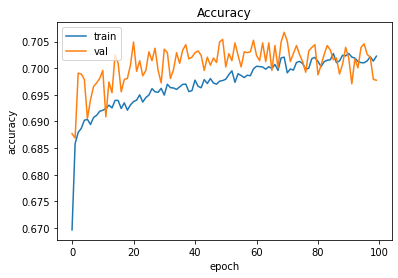

In [734]:
# Plot accuracy of train and validation datasets 

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.show()
#plt.savefig("Accuracy_val_multi.png")

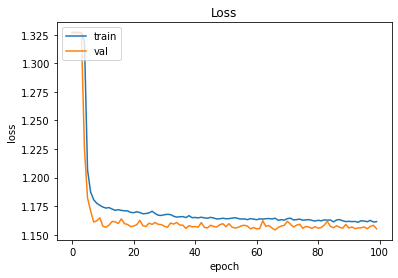

In [660]:
# summarize history for loss of train and validation datasets

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.show()
#plt.savefig("Loss_val_multi.png")

In [735]:
# Load best model from the checkpoint and evaluate performance

model_check = load_model("checkpoint.h5")
y_eval = model_check.evaluate(X_test,y_test
                                ,verbose=2)

6651/1 - 1s - loss: 0.6254 - accuracy: 0.6957


In [736]:
# Obtain predictions

y_pred = model_check.predict(X_test)

y_pred

array([[0.69795793],
       [0.39170772],
       [0.8112625 ],
       ...,
       [0.5628231 ],
       [0.55739635],
       [0.54758036]], dtype=float32)

In [737]:
# Round value of predictions to get a binary result (0 or 1)

y_pred_res = np.round(y_pred)
y_pred_res

array([[1.],
       [0.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [738]:
# Print metrics out

print("The model accuracy is: ",round(100*accuracy_score(y_test,y_pred_res),2),"%")
print("")
print(confusion_matrix(y_test,y_pred_res))
print("")
print(classification_report(y_test,y_pred_res))

The model accuracy is:  69.57 %

[[3079  812]
 [1212 1548]]

              precision    recall  f1-score   support

         0.0       0.72      0.79      0.75      3891
         1.0       0.66      0.56      0.60      2760

    accuracy                           0.70      6651
   macro avg       0.69      0.68      0.68      6651
weighted avg       0.69      0.70      0.69      6651



In [741]:
# Print weighted average metrics

precision_recall_fscore_support(y_test,y_pred_res, average='weighted')

(0.6919791818591788, 0.6956848594196361, 0.6912361984849191, None)

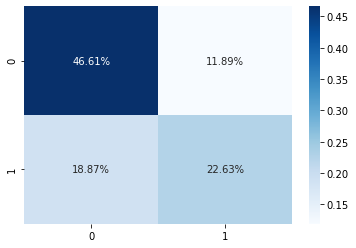

In [642]:
# Plot confusion matrix

cf_mat = confusion_matrix(y_test,y_pred_res)
sns.heatmap(cf_mat/np.sum(cf_mat),cmap='Blues', annot=True,fmt='.2%').get_figure().savefig("Conf_mat_binary.png")


## Multi-class Deep Neural Network

The scope of the model can be increased, by analysing this as a multi-class classification problem rather than a binary classification problem. The dataset used has four classes, as follows:

0. Offer Viewed and Completed
1. Offer Not Viewed but Completed
2. Offer Viewed but Not Completed
3. Offer Not Viewed and Not Completed

The original model can be adapted to the multi-class model by doing several steps. First, the y-data that includes the labels are still a 1-D array, but rather that being binary (0 or 1) it has four possible values (0, 1, 2 or 3). 


In [776]:
# Split test train data

X_train, X_test, y_train, y_test = train_test_split(class_X, class_Y_df.to_numpy(), test_size=0.1, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(class_X, pd.DataFrame(class_y["V_C"]).to_numpy(), test_size=0.1, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# Define data pre-processing scalers

scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
variance = VarianceThreshold()

# Apply scaling

X_train = scaler.fit_transform(X_train)
#y_train = y_scaler.fit_transform(y_train)
X_train = variance.fit_transform(X_train)

X_test = scaler.transform(X_test)
#y_test = y_scaler.transform(y_test)
X_test = variance.transform(X_test)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(59850, 16)
(6651, 16)
(59850, 1)
(6651, 1)
(59850, 15)
(6651, 15)
(59850, 1)
(6651, 1)


In [777]:
y_train

array([[0.],
       [3.],
       [2.],
       ...,
       [2.],
       [3.],
       [2.]])

In [778]:
inputs = keras.Input(shape=X_train.shape[1])
x = layers.Dense(512*2, activation="relu")(inputs)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation="relu")(x)
out_vc = layers.Dense(4,activation="softmax", name="view_out")(x)


In [779]:
# Define model

model = keras.Model(inputs=inputs, outputs=out_vc, name="model")

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 15)]              0         
_________________________________________________________________
dense_80 (Dense)             (None, 1024)              16384     
_________________________________________________________________
dropout_57 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_81 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_58 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_59 (Dropout)         (None, 256)               0     

In [780]:
# Compile mode, define loss, optimizer and metrics

model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
#model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


In [781]:
checkpoint_filepath = 'checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(monitor='val_accuracy',
                                            filepath=checkpoint_filepath,mode='max',save_best_only=True)


In [782]:
# Train model

history = model.fit(X_train,y_train,
    epochs=100,
    batch_size=32,
    validation_split = 0.1,
    verbose = 2,
    callbacks=[model_checkpoint_callback]

)

Train on 53865 samples, validate on 5985 samples
Epoch 1/100
53865/53865 - 14s - loss: 1.2103 - accuracy: 0.5155 - val_loss: 1.1818 - val_accuracy: 0.5462
Epoch 2/100
53865/53865 - 13s - loss: 1.1869 - accuracy: 0.5382 - val_loss: 1.1733 - val_accuracy: 0.5522
Epoch 3/100
53865/53865 - 12s - loss: 1.1812 - accuracy: 0.5404 - val_loss: 1.1685 - val_accuracy: 0.5557
Epoch 4/100
53865/53865 - 13s - loss: 1.1788 - accuracy: 0.5443 - val_loss: 1.1667 - val_accuracy: 0.5627
Epoch 5/100
53865/53865 - 12s - loss: 1.1771 - accuracy: 0.5472 - val_loss: 1.1637 - val_accuracy: 0.5652
Epoch 6/100
53865/53865 - 13s - loss: 1.1769 - accuracy: 0.5488 - val_loss: 1.1609 - val_accuracy: 0.5649
Epoch 7/100
53865/53865 - 13s - loss: 1.1736 - accuracy: 0.5540 - val_loss: 1.1638 - val_accuracy: 0.5586
Epoch 8/100
53865/53865 - 12s - loss: 1.1740 - accuracy: 0.5502 - val_loss: 1.1597 - val_accuracy: 0.5651
Epoch 9/100
53865/53865 - 12s - loss: 1.1735 - accuracy: 0.5501 - val_loss: 1.1586 - val_accuracy: 0.56

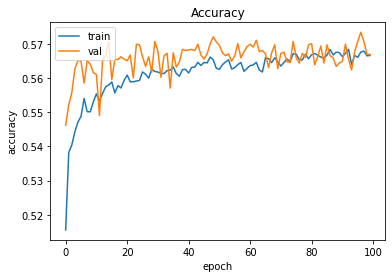

In [783]:
# Plot accuracy of train and validation datasets 

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.show()
#plt.savefig("Accuracy_val_multi.png")

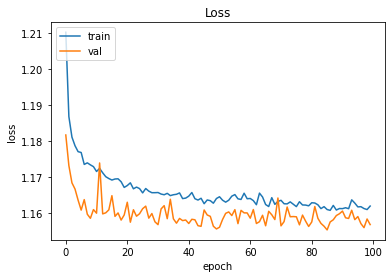

In [784]:
# summarize history for loss of train and validation datasets

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.show()
#plt.savefig("Loss_val_multi.png")

In [785]:
# Load best model from the checkpoint and evaluate performance

model_check = load_model("checkpoint.h5")
y_eval = model_check.evaluate(X_test,y_test
                                ,verbose=2)

6651/1 - 1s - loss: 1.2104 - accuracy: 0.5634


In [786]:
# Obtain predictions

y_pred = model_check.predict(X_test)

y_pred

array([[1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [6.3079399e-01, 2.9767784e-13, 2.0079130e-10, 3.6920604e-01],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       ...,
       [1.0000000e+00, 7.3280103e-13, 5.9505879e-21, 1.0738602e-35],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [6.5556556e-01, 7.1880577e-06, 3.4442714e-01, 1.0316683e-07]],
      dtype=float32)

In [787]:
# Convert 4D predictions into 1d prediction with values from 0 to 3

y_pred_res_2 = (y_pred == y_pred.max(axis=1)[:,None]).astype(int)


y_pred_all = []

for i in range(0,len(y_pred)):
    pred = np.argmax(y_pred[i])
    y_pred_all.append(pred)
    
y_pred_all

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

In [797]:
# Print metrics

print(accuracy_score(y_test,y_pred_all))
print("")
print(confusion_matrix(y_test,y_pred_all))
print("")
print(classification_report(y_test,y_pred_all))

0.5633739287325215

[[1960  195  413  192]
 [ 474  330   78  136]
 [ 661   71  792  197]
 [ 276  136   75  665]]

              precision    recall  f1-score   support

         0.0       0.58      0.71      0.64      2760
         1.0       0.45      0.32      0.38      1018
         2.0       0.58      0.46      0.51      1721
         3.0       0.56      0.58      0.57      1152

    accuracy                           0.56      6651
   macro avg       0.54      0.52      0.52      6651
weighted avg       0.56      0.56      0.55      6651



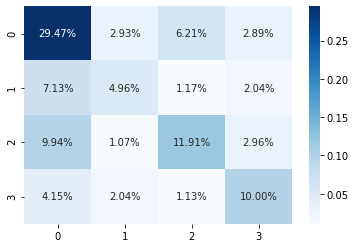

In [791]:
cf_mat_multi = confusion_matrix(y_test,y_pred_all)
sns.heatmap(cf_mat_multi/np.sum(cf_mat_multi),cmap='Blues', annot=True,fmt='.2%')#.get_figure().savefig("Conf_mat_multi.png")
